# Импорт библиотек

In [1]:
import os
import numpy as np
import pandas as pd
news = pd.read_csv('texts.csv')
pd.set_option("display.max_rows", 200)
#messages = pd.read_csv('news.csv')
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing 
from sklearn.neighbors import KNeighborsClassifier
import mlxtend
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import numpy as np   
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn import preprocessing
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.dummy import DummyClassifier

In [2]:
#res = pd.read_csv('result_2.csv')
res = pd.read_csv('result_3.csv')
stop_words = nltk.corpus.stopwords.words('russian')
res['has news'] = res['message'].notna()

In [3]:
num_of_news = pd.DataFrame(res[['<TICKER>', 'has news']].groupby(['<TICKER>'])['has news'].sum())

# Функции

In [27]:
def create_features(df, label=None):
    df['date'] = df.index
    df['day'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    #df['movingavg4weeks'] = round(df['<CLOSE>'].rolling(window=(4*5), min_periods = 1).mean().shift(),2)
    #df['movingavg16weeks'] = round(df['<CLOSE>'].rolling(window=(16*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 4 weeks 
    #df['movingavg28weeks'] = round(df['<CLOSE>'].rolling(window=(28*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 16 weeks
    #df['movingavg40weeks'] = round(df['<CLOSE>'].rolling(window=(40*5), min_periods = 1).mean().shift(),2) #add 12 weeks to 28 weeks
    #df['movingavg52weeks'] = round(df['<CLOSE>'].rolling(window=(52*5), min_periods = 1).mean().shift(),2)  #add 12 weeks to 40 weeks
    #df['window1days'] = round(df['<CLOSE>'].rolling(window = 1, min_periods = 1).mean().shift(),2)  
    #df['window2days'] = round(df['<CLOSE>'].rolling(window = 2, min_periods = 1).mean().shift(),2)
    #df['window3days'] = round(df['<CLOSE>'].rolling(window = 3, min_periods = 1).mean().shift(),2)  
    #df['window4days'] = round(df['<CLOSE>'].rolling(window = 4, min_periods = 1).mean().shift(),2)
    #df['window10days'] = round(df['<CLOSE>'].rolling(window = 10, min_periods = 1).mean().shift(),2)  
    #df['window50days'] = round(df['<CLOSE>'].rolling(window = 50, min_periods = 1).mean().shift(),2)
    #df['price'] = round((df['<HIGH>'] + df['<LOW>'] + df['<CLOSE>']) / 3 , 2)
    df['delta'] = (df['<CLOSE>']+df['<OPEN>']+df['<HIGH>']+df['<LOW>'])/4 - (df['<CLOSE>'].shift(1)
                                                                            +df['<OPEN>'].shift(1)
                                                                            +df['<HIGH>'].shift(1)
                                                                            +df['<LOW>'].shift(1))

# Цикл метрик для топ 5 компаний  через 10 минут

In [5]:
ticker_list = ['GOOG-RM','FIVE','SBER','RBCM','YNDX','AFLT','GMKN', 'MGNT',
               'GAZP','MAIL','MTSS','RUAL','TCSG','ROSN','FB-RM','LKOH','AAPL-RM','VTBR']
#ticker_list = list(res['<TICKER>'].unique())
company = []
period = []
train = []
test = []
model = []
f1 = []

In [6]:
ticker_list

['GOOG-RM',
 'FIVE',
 'SBER',
 'RBCM',
 'YNDX',
 'AFLT',
 'GMKN',
 'MGNT',
 'GAZP',
 'MAIL',
 'MTSS',
 'RUAL',
 'TCSG',
 'ROSN',
 'FB-RM',
 'LKOH',
 'AAPL-RM',
 'VTBR']

In [34]:
res.dropna()

,Unnamed: 0,<TICKER>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,message,date,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,raw_news,lem_message,has news
0,0,GOOG-RM,118516.688312,118516.688312,118516.688312,118516.688312,как сменить профессию в 30 лет и создать успеш...,2020-08-24,118516.688312,0.000000,1.0,0.000000,118516.688312,0.000000,1.0,0.000000,как сменить профессию в 30 лет и создать успеш...,как сменить профессия в 30 год и создать успеш...,True
1,1,GOOG-RM,118516.688312,118516.688312,118516.688312,118516.688312,"#телекомы #индексы \n📊 facebook, amazon, apple...",2020-08-24,118516.688312,0.000000,1.0,0.000000,119947.783333,1431.095022,1.0,0.012075,"#телекомы #индексы \n📊 facebook, amazon, apple...",телеком индекс facebook amazon apple microsof...,True
2,2,GOOG-RM,118516.688312,118516.688312,118516.688312,118516.688312,топ-10 акций сша на мосбирже по объему сделок ...,2020-08-24,119937.991667,1421.303355,1.0,0.011992,122854.384615,4337.696304,1.0,0.036600,топ-10 акций сша на мосбирже по объему сделок ...,топ 10 акция сша на мосбиржа по объём сделка в...,True
4,4,GOOG-RM,122854.384615,122963.461538,122827.276923,122892.738462,​​риски инвестирования в акции. так ли страшен...,2020-08-26,122884.465385,0.000000,1.0,0.000245,124112.392857,1258.008242,1.0,0.010240,​​риски инвестирования в акции. так ли страшен...,риск инвестирование в акция так ли страшный р...,True
5,5,GOOG-RM,122854.384615,122963.461538,122827.276923,122892.738462,"суммарная капитализация apple, amazon, microso...",2020-08-26,124103.147321,1218.681937,1.0,0.010165,122094.272727,-760.111888,-1.0,-0.006187,"суммарная капитализация apple, amazon, microso...",суммарный капитализация apple amazon microsoft...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37479,37479,VTBR,0.047973,0.048078,0.047882,0.047980,#инвестидея \n\nдля квалифицированных инвестор...,2021-12-07,0.047978,0.000000,1.0,0.000110,0.047973,0.000000,1.0,0.000000,#инвестидея \n\nдля квалифицированных инвестор...,инвестидея для квалифицировать инвестор us gl...,True
37480,37480,VTBR,0.047973,0.048078,0.047882,0.047980,втб самостоятельно подключает части клиентов п...,2021-12-07,0.047978,0.000000,1.0,0.000110,0.047973,0.000000,1.0,0.000000,втб самостоятельно подключает части клиентов п...,втб самостоятельно подключать часть клиент пак...,True
37481,37481,VTBR,0.047973,0.048078,0.047882,0.047980,"первый запред втб юрий соловьев рассказал, ком...",2021-12-07,0.047978,0.000000,1.0,0.000110,0.047973,0.000000,1.0,0.000000,"первый запред втб юрий соловьев рассказал, ком...",первый запред втб юрий соловьёв рассказать кто...,True
37482,37482,VTBR,0.047973,0.048078,0.047882,0.047980,​​📉 как посчитать справедливую стоимость афк с...,2021-12-07,0.047978,0.000000,1.0,0.000110,0.048013,0.000040,1.0,0.000832,​​📉 как посчитать справедливую стоимость афк с...,как посчитать справедливый стоимость афк сист...,True


In [7]:
def scores(how):

    for ticker in ticker_list: 
        YNDX = res[res['<TICKER>'] == ticker]
        YNDX = YNDX[['<TICKER>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7', 'lem_message']]
        YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date','y_3',
                             'y_7'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
        YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
        YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
        create_features(YNDX)
        #pd.get_dummies(YNDX, columns=['<TICKER>'])
        YNDX = YNDX.drop(labels=['date'], axis=1)
        YNDX = YNDX.dropna()
        Y_3 = YNDX['y_3']
        Y_7 = YNDX['y_7']
        YNDX = YNDX.drop(labels=['<TICKER>', 'y_3', 'y_7'], axis=1)
        X = YNDX
        split = int(len(X)*0.7)
        X_train, X_test = YNDX.iloc[:split, :], YNDX.iloc[split:, :]
        y_train_3, y_test_3 = Y_3.iloc[:split], Y_3.iloc[split:]
        y_train_7, y_test_7 = Y_7.iloc[:split], Y_7.iloc[split:]
        
        res_1 = res.dropna()

        # train

        tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                ngram_range=(1,1), 
                                stop_words=stop_words, max_features=4000)

        tfidf.fit(res_1['lem_message'])
        features_train = tfidf.transform(X_train['lem_message'])

        # test

        tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                ngram_range=(1,1), 
                                stop_words=stop_words, max_features=4000)
        tfidf.fit(res_1['lem_message'])
        features_test = tfidf.transform(X_test['lem_message'])
        features_train = tfidf.transform(X_train['lem_message'])
        X_train = X_train.drop(labels=['lem_message'], axis=1)
        X_test = X_test.drop(labels=['lem_message'], axis=1)

        # train



        normalizer = preprocessing.StandardScaler()
        train_norm = normalizer.fit_transform(X_train)
        train_transformed = pd.DataFrame(data=train_norm, columns = X_train.columns)

        normalizer = preprocessing.StandardScaler()
        test_norm = normalizer.fit_transform(X_test)
        test_transformed = pd.DataFrame(data=test_norm, columns = X_test.columns)

        df_train, df_test = features_train.todense(), features_test.todense()

        X_data_train, X_data_test = np.append(X_train, df_train, axis = 1), np.append(X_test, df_test, axis = 1)

        #print(X_data_train.shape, ' ',X_data_test.shape)
        print('Обучается '+ticker)

        X_tr = np.array(X_data_train)
        y_tr_3 = np.array(y_train_3)
        y_tr_7 = np.array(y_train_7)

        clf1 = LogisticRegression(random_state=1,
                                  solver='newton-cg',
                                  multi_class='ovr')
        clf3 = RidgeClassifier()
        labels = ['Logistic Regression', 'Ridge']
        
        if how == 'report':
        

            models = [clf1, clf3]
            print('------------------------'+'1 day'+'------------------------')
            for clf, lab in zip(models, labels):
                clf.fit(X_data_train, y_train_3)
                print('------------------------'+ticker+'------------------------')
                print('------------------------'+lab+'------------------------')
                y_test_pred = clf.predict(X_data_test)
                arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                print(confusion_matrix(**arg_test))
                print(classification_report(**arg_test))

            models = [clf1, clf3]
            print('------------------------'+'2 days'+'------------------------')
            for clf, lab in zip(models, labels):
                clf.fit(X_data_train, y_train_7)
                print('------------------------'+ticker+'------------------------')
                print('------------------------'+lab+'------------------------')
                y_test_pred = clf.predict(X_data_test)
                arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                print(confusion_matrix(**arg_test))
                print(classification_report(**arg_test))
                
        elif how == 'table':

            # делаем таблицу
            for clf, lab in zip([clf1, clf3],
                                 labels):

                company.append(ticker)
                period.append('1 day')
                model.append(lab)
                y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                test.append(np.mean(y_test_3==y_predicted_test))
                f1.append(f1_score(y_test_3, y_predicted_test,
                                                                        average = 'weighted'))
                y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                train.append(np.mean(y_train_3==y_predicted_train))
                
            for clf, lab in zip([clf1, clf3],
                                 labels):

                company.append(ticker)
                period.append('2 days')
                model.append(lab)
                y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                test.append(np.mean(y_test_7==y_predicted_test))
                f1.append(f1_score(y_test_7, y_predicted_test, 
                                                                        average = 'weighted'))
                y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                train.append(np.mean(y_train_7==y_predicted_train))
                
            tab = {'f1_score':f1, 'company': company, 'period': period,'model': model, 'Train': train , 'Test': test}
            tabl = pd.DataFrame(tab, columns = ['company', 'period', 'model','Train', 'Test', 'f1_score'])
        else: 
            return 'error'
    if how == 'table':
        return tabl

In [8]:
report = scores(how = 'table')

Обучается GOOG-RM
Обучается FIVE
Обучается SBER
Обучается RBCM
Обучается YNDX
Обучается AFLT
Обучается GMKN
Обучается GAZP
Обучается MAIL
Обучается MTSS
Обучается RUAL
Обучается TCSG
Обучается ROSN
Обучается FB-RM
Обучается LKOH
Обучается AAPL-RM
Обучается VTBR


In [9]:
report = report.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

In [10]:
def scores_without_texts(how):

    for ticker in ticker_list: 
        YNDX = res[res['<TICKER>'] == ticker]
        YNDX = YNDX[['<TICKER>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7', 'lem_message']]
        YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3',
                             'y_7'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
        YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
        YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
        create_features(YNDX)
        #pd.get_dummies(YNDX, columns=['<TICKER>'])
        YNDX = YNDX.drop(labels=['date'], axis=1)
        YNDX = YNDX.dropna()
        Y_3 = YNDX['y_3']
        Y_7 = YNDX['y_7']
        YNDX = YNDX.drop(labels=['<TICKER>', 'y_3', 'y_7'], axis=1)
        X = YNDX
        split = int(len(X)*0.7)
        X_train, X_test = YNDX.iloc[:split, :], YNDX.iloc[split:, :]
        y_train_3, y_test_3 = Y_3.iloc[:split], Y_3.iloc[split:]
        y_train_7, y_test_7 = Y_7.iloc[:split], Y_7.iloc[split:]

        X_train = X_train.drop(labels=['lem_message'], axis=1)
        X_test = X_test.drop(labels=['lem_message'], axis=1)

        # train

        normalizer = preprocessing.StandardScaler()
        train_norm = normalizer.fit_transform(X_train)
        train_transformed = pd.DataFrame(data=train_norm, columns = X_train.columns)

        normalizer = preprocessing.StandardScaler()
        test_norm = normalizer.fit_transform(X_test)
        test_transformed = pd.DataFrame(data=test_norm, columns = X_test.columns)


        X_data_train, X_data_test = X_train, X_test

        #print(X_data_train.shape, ' ',X_data_test.shape)
        #print('Обучается '+ticker)

        X_tr = np.array(X_data_train)
        y_tr_3 = np.array(y_train_3)
        y_tr_7 = np.array(y_train_7)

        clf1 = LogisticRegression(random_state=1,
                                  solver='newton-cg',
                              multi_class='ovr')
        clf3 = RidgeClassifier()
        labels = ['Logistic Regression', 'Ridge']
        
        if how == 'report':
        

            models = [clf1, clf3]
            print('------------------------'+'1 day'+'------------------------')
            for clf, lab in zip(models, labels):
                clf.fit(X_data_train, y_train_3)
                print('------------------------'+ticker+'------------------------')
                print('------------------------'+lab+'------------------------')
                y_test_pred = clf.predict(X_data_test)
                arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                print(confusion_matrix(**arg_test))
                print(classification_report(**arg_test))

            models = [clf1, clf3]
            print('------------------------'+'2 days'+'------------------------')
            for clf, lab in zip(models, labels):
                clf.fit(X_data_train, y_train_7)
                print('------------------------'+ticker+'------------------------')
                print('------------------------'+lab+'------------------------')
                y_test_pred = clf.predict(X_data_test)
                arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                print(confusion_matrix(**arg_test))
                print(classification_report(**arg_test))
                
        elif how == 'table':

            # делаем таблицу
            for clf, lab in zip([clf1, clf3],
                                 labels):

                company.append(ticker)
                period.append('1 day')
                model.append(lab)
                y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                test.append(np.mean(y_test_3==y_predicted_test))
                f1.append(f1_score(y_test_3, y_predicted_test, 
                                                                        average = 'weighted'))
                y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                train.append(np.mean(y_train_3==y_predicted_train))
                                  
            for clf, lab in zip([clf1, clf3],
                                 labels):

                company.append(ticker)
                period.append('2 days')
                model.append(lab)
                y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                test.append(np.mean(y_test_7==y_predicted_test))
                f1.append(f1_score(y_test_7, y_predicted_test, 
                                                                        average = 'weighted'))
                y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                train.append(np.mean(y_train_7==y_predicted_train))
                
            tab = {'f1_score':f1, 'company': company, 'period': period,'model': model, 'Train': train , 'Test': test}
            tabl = pd.DataFrame(tab, columns = ['company', 'period', 'model','Train', 'Test', 'f1_score'])
        else: 
            return 'error'
    if how == 'table':
        return tabl

In [11]:
company = []
period = []
train = []
test = []
model = []
f1 = []

In [12]:
report_1 = scores_without_texts(how = 'table')

In [13]:
report_1 = report_1.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

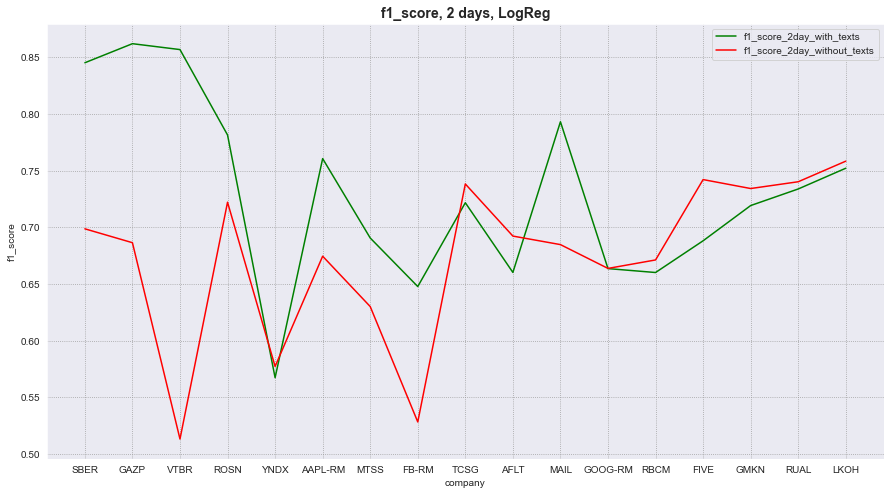

In [14]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 2 days, LogReg', weight='bold').set_fontsize('14')
metric = report[(report['period']=='2 days') & (report['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_2day_with_texts')
sns.lineplot(x=report_1[(report_1['period']=='2 days') & (report_1['model']=='Logistic Regression')]['company'],
             y=report_1[(report_1['period']=='2 days') & (report_1['model']=='Logistic Regression')]['f1_score'], color='red', label='f1_score_2day_without_texts')
plt.show()

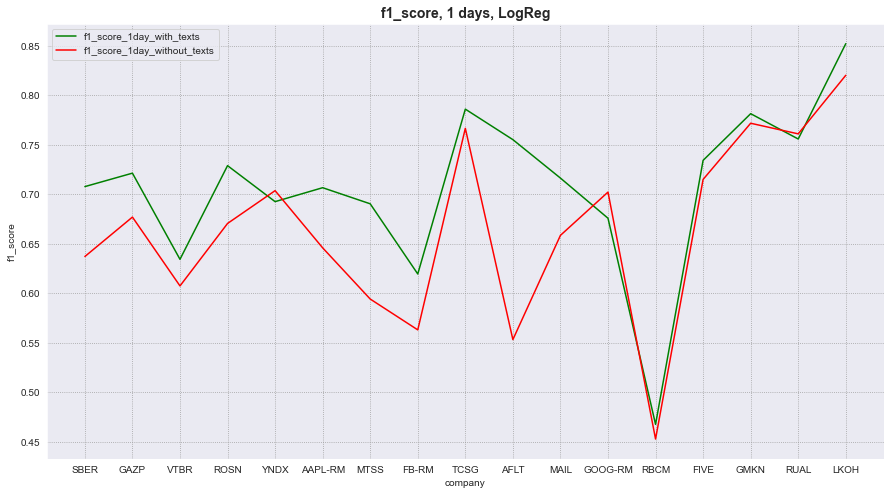

In [15]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 1 days, LogReg', weight='bold').set_fontsize('14')
metric = report[(report['period']=='1 day') & (report['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_1day_with_texts')
sns.lineplot(x=report_1[(report_1['period']=='1 day') & (report_1['model']=='Logistic Regression')]['company'],
             y=report_1[(report_1['period']=='1 day') & (report_1['model']=='Logistic Regression')]['f1_score'], color='red', label='f1_score_1day_without_texts')
plt.show()

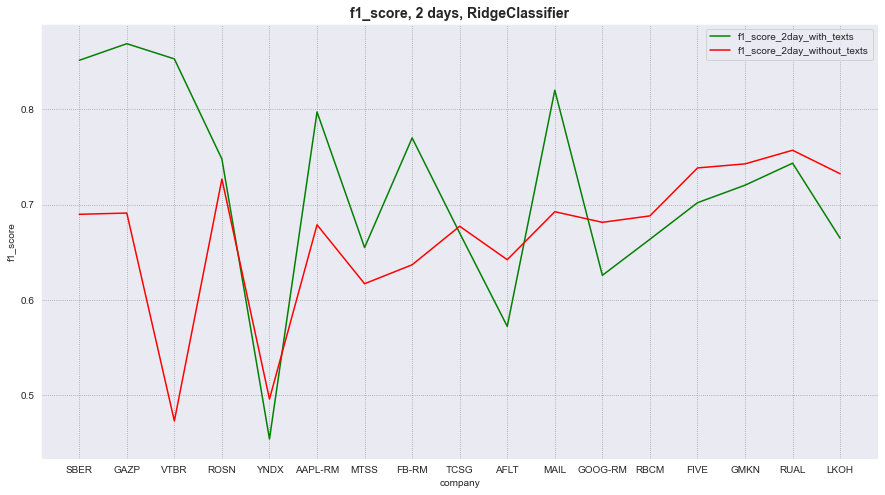

In [16]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 2 days, RidgeClassifier', weight='bold').set_fontsize('14')
metric = report[(report['period']=='2 days') & (report['model']=='Ridge')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_2day_with_texts')
sns.lineplot(x=report_1[(report_1['period']=='2 days') & (report_1['model']=='Ridge')]['company'],
             y=report_1[(report_1['period']=='2 days') & (report_1['model']=='Ridge')]['f1_score'], color='red', label='f1_score_2day_without_texts')
plt.show()

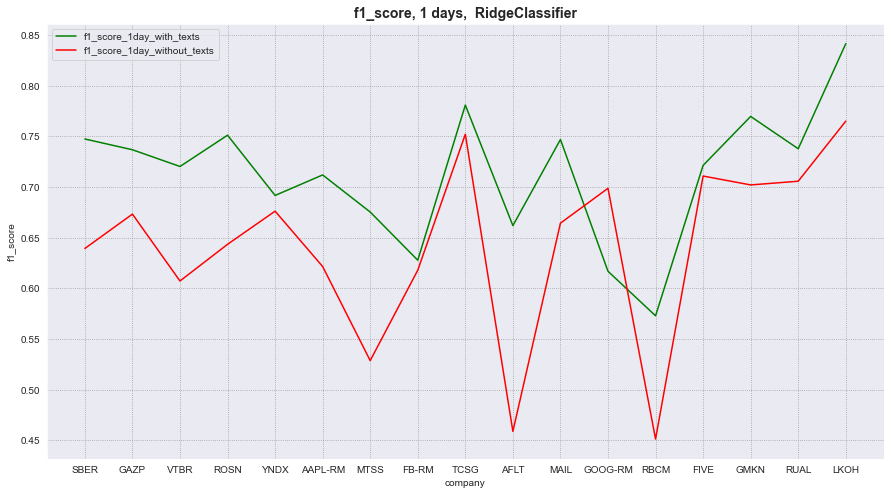

In [17]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 1 days,  RidgeClassifier', weight='bold').set_fontsize('14')
metric = report[(report['period']=='1 day') & (report['model']=='Ridge')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_1day_with_texts')
sns.lineplot(x=report_1[(report_1['period']=='1 day') & (report_1['model']=='Ridge')]['company'],
             y=report_1[(report_1['period']=='1 day') & (report_1['model']=='Ridge')]['f1_score'], color='red', label='f1_score_1day_without_texts')
plt.show()

# то же самое но с дропом нанов (прогнала)

In [136]:
company = []
period = []
train = []
test = []
model = []
f1 = []

In [137]:
def scores_1(how):
    YNDX = res
    YNDX = YNDX[['<TICKER>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7', 'lem_message', 'message']]
    YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'message',
                             'y_7'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
    YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
    YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
    create_features(YNDX)
    pd.get_dummies(YNDX, columns=['<TICKER>'])
    YNDX = YNDX.drop(labels=['date'], axis=1)
    YNDX = YNDX.dropna()
    Y_3 = YNDX['y_3']
    Y_7 = YNDX['y_7']
    YNDX = YNDX.drop(labels=['<TICKER>', 'y_3', 'y_7'], axis=1)
    X = YNDX
    tscv = TimeSeriesSplit()
        
    for train_index, test_index in tscv.split(X): #я остановилась тут
        split_1 = train_index[-1]+1
        split_2 = test_index[-1]+1
        X_train, X_test = YNDX.iloc[:split_1, :], YNDX.iloc[split_1:split_2, :]
        y_train_3, y_test_3 = Y_3.iloc[:split_1], Y_3.iloc[split_1:split_2]
        y_train_7, y_test_7 = Y_7.iloc[:split_1], Y_7.iloc[split_1:split_2]

        res_1 = res.dropna()

        tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                ngram_range=(1,2), 
                                stop_words=stop_words, max_features=1000)

        tfidf.fit(res_1['lem_message'])
        features_train = tfidf.transform(X_train['lem_message'])

            # test

        tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=1000)
        tfidf.fit(res_1['lem_message'])
        features_test = tfidf.transform(X_test['lem_message'])
        features_train = tfidf.transform(X_train['lem_message'])
        X_train = X_train.drop(labels=['lem_message', 'message'], axis=1)
        X_test = X_test.drop(labels=['lem_message', 'message'], axis=1)

            # train



        normalizer = preprocessing.StandardScaler()
        train_norm = normalizer.fit_transform(X_train)
        train_transformed = pd.DataFrame(data=train_norm, columns = X_train.columns)

        normalizer = preprocessing.StandardScaler()
        test_norm = normalizer.fit_transform(X_test)
        test_transformed = pd.DataFrame(data=test_norm, columns = X_test.columns)

        df_train, df_test = features_train.todense(), features_test.todense()

        X_data_train, X_data_test = np.append(X_train, df_train, axis = 1), np.append(X_test, df_test, axis = 1)





        X_tr = np.array(X_data_train)
        y_tr_3 = np.array(y_train_3)
        y_tr_7 = np.array(y_train_7)

        clf1 = LogisticRegression(random_state=1,
                                      solver='newton-cg',
                                      multi_class='ovr')
        clf2 = RidgeClassifier()
        clf3 = SVC()
        clf4 = RandomForestClassifier()
        clf5 = AdaBoostClassifier()
        clf6 = DummyClassifier(strategy = 'prior')
        labels = ['Logistic Regression', 'Ridge', 'SVM', 'Random Forest', 'AdaBoost', 'Rand']

        if how == 'report':


            models = [clf1, clf3]
            print('------------------------'+'1 day'+'------------------------')
            for clf, lab in zip(models, labels):
                clf.fit(X_data_train, y_train_3)
                print('------------------------'+lab+'------------------------')
                y_test_pred = clf.predict(X_data_test)
                arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                print(confusion_matrix(**arg_test))
                print(classification_report(**arg_test))

            models = [clf1, clf3]
            print('------------------------'+'2 days'+'------------------------')
            for clf, lab in zip(models, labels):
                clf.fit(X_data_train, y_train_7)
                print('------------------------'+lab+'------------------------')
                y_test_pred = clf.predict(X_data_test)
                arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                print(confusion_matrix(**arg_test))
                print(classification_report(**arg_test))

        elif how == 'table':

                # делаем таблицу
            for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):


                period.append('1 day')
                model.append(lab)
                y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                test.append(accuracy_score(y_test_3, y_predicted_test))
                f1.append(f1_score(y_test_3, y_predicted_test,
                                                                            average = 'weighted'))
                y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                train.append(np.mean(y_train_3==y_predicted_train))

            for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):


                period.append('2 days')
                model.append(lab)
                y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                test.append(accuracy_score(y_test_7, y_predicted_test))
                f1.append(f1_score(y_test_7, y_predicted_test, 
                                                                            average = 'weighted'))
                y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                train.append(np.mean(y_train_7==y_predicted_train))
                
        tab = {'f1_score':f1, 'period': period,'model': model, 'Train': train , 'Test': test}
        tabl = pd.DataFrame(tab, columns = ['period', 'model','Train', 'Test', 'f1_score'])

    if how == 'table':
        return tabl

In [138]:
def scores_without_texts_1(how):

    YNDX = res
    YNDX = YNDX[['<TICKER>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7', 'lem_message', 'message']]
    YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3',
                             'y_7', 'message'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
    YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
    YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
    create_features(YNDX)
    pd.get_dummies(YNDX, columns=['<TICKER>'])
    YNDX = YNDX.drop(labels=['date'], axis=1)
    YNDX = YNDX.dropna()
    Y_3 = YNDX['y_3']
    Y_7 = YNDX['y_7']
    YNDX = YNDX.drop(labels=['<TICKER>', 'y_3', 'y_7'], axis=1)
    X = YNDX
    tscv = TimeSeriesSplit()
        

    for train_index, test_index in tscv.split(X): #я остановилась тут
        split_1 = train_index[-1]+1
        split_2 = test_index[-1]+1
        X_train, X_test = YNDX.iloc[:split_1, :], YNDX.iloc[split_1:split_2, :]
        y_train_3, y_test_3 = Y_3.iloc[:split_1], Y_3.iloc[split_1:split_2]
        y_train_7, y_test_7 = Y_7.iloc[:split_1], Y_7.iloc[split_1:split_2]
        X_train = X_train.drop(labels=['lem_message', 'message'], axis=1)
        X_test = X_test.drop(labels=['lem_message', 'message'], axis=1)

            # train

        normalizer = preprocessing.StandardScaler()
        train_norm = normalizer.fit_transform(X_train)
        train_transformed = pd.DataFrame(data=train_norm, columns = X_train.columns)

        normalizer = preprocessing.StandardScaler()
        test_norm = normalizer.fit_transform(X_test)
        test_transformed = pd.DataFrame(data=test_norm, columns = X_test.columns)


        X_data_train, X_data_test = X_train, X_test

            #print(X_data_train.shape, ' ',X_data_test.shape)
            #print('Обучается '+ticker)

        X_tr = np.array(X_data_train)
        y_tr_3 = np.array(y_train_3)
        y_tr_7 = np.array(y_train_7)

        clf1 = LogisticRegression(random_state=1,
                                      solver='newton-cg',
                                  multi_class='ovr')
        clf2 = RidgeClassifier()
        clf3 = SVC()
        clf4 = RandomForestClassifier()
        clf5 = AdaBoostClassifier()
        clf6 = DummyClassifier(strategy = 'prior')
        labels = ['Logistic Regression', 'Ridge', 'SVM', 'Random Forest', 'AdaBoost', 'Rand']

        if how == 'report':


            models = [clf1, clf2, clf3, clf4, clf5, clf6]
            print('------------------------'+'1 day'+'------------------------')
            for clf, lab in zip(models, labels):
                clf.fit(X_data_train, y_train_3)
                print('------------------------'+lab+'------------------------')
                y_test_pred = clf.predict(X_data_test)
                arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                print(confusion_matrix(**arg_test))
                print(classification_report(**arg_test))

            models = [clf1, clf2, clf3, clf4, clf5, clf6]
            print('------------------------'+'2 days'+'------------------------')
            for clf, lab in zip(models, labels):
                clf.fit(X_data_train, y_train_7)
                print('------------------------'+lab+'------------------------')
                y_test_pred = clf.predict(X_data_test)
                arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                print(confusion_matrix(**arg_test))
                print(classification_report(**arg_test))

        elif how == 'table':

                # делаем таблицу
            for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                period.append('1 day')
                model.append(lab)
                y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                test.append(np.mean(y_test_3==y_predicted_test))
                f1.append(f1_score(y_test_3, y_predicted_test, 
                                                                            average = 'weighted'))
                y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                train.append(np.mean(y_train_3==y_predicted_train))

            for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                period.append('2 days')
                model.append(lab)
                y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                test.append(np.mean(y_test_7==y_predicted_test))
                f1.append(f1_score(y_test_7, y_predicted_test, 
                                                                            average = 'weighted'))
                y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                train.append(np.mean(y_train_7==y_predicted_train))
                
        tab = {'f1_score':f1, 'period': period,'model': model, 'Train': train , 'Test': test}
        tabl = pd.DataFrame(tab, columns = ['period', 'model','Train', 'Test', 'f1_score'])
            
    if how == 'table':
        return tabl

In [139]:
report_2 = scores_1(how = 'table')

In [140]:
report_2 = report_2.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

KeyError: 'company'

In [141]:
company = []
period = []
train = []
test = []
model = []
f1 = []

In [142]:
report_3 = scores_without_texts_1(how = 'table')

KeyboardInterrupt: 

In [ ]:
report_3 = report_3.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

In [143]:
f1_1 = pd.DataFrame(report_2[['period', 'model', 'f1_score', 'Test']]
                    .groupby(['period', 'model'])['f1_score', 'Test'].mean())
f1_1

f1_score      Test
period model                                  
1 day  AdaBoost             0.802903  0.846652
       Logistic Regression  0.800915  0.853687
       Rand                 0.796383  0.860760
       Random Forest        0.797477  0.858277
       Ridge                0.801402  0.852182
       SVM                  0.796456  0.860760
2 days AdaBoost             0.692924  0.745335
       Logistic Regression  0.689151  0.751768
       Rand                 0.663683  0.765350
       Random Forest        0.687981  0.753687
       Ridge                0.688441  0.748232
       SVM                  0.665673  0.763807

In [ ]:
f1_2 = pd.DataFrame(report_3[['company', 'period', 'model', 'f1_score', 'Test']]
                    .groupby(['period', 'model'])['f1_score', 'Test'].mean())
f1_2

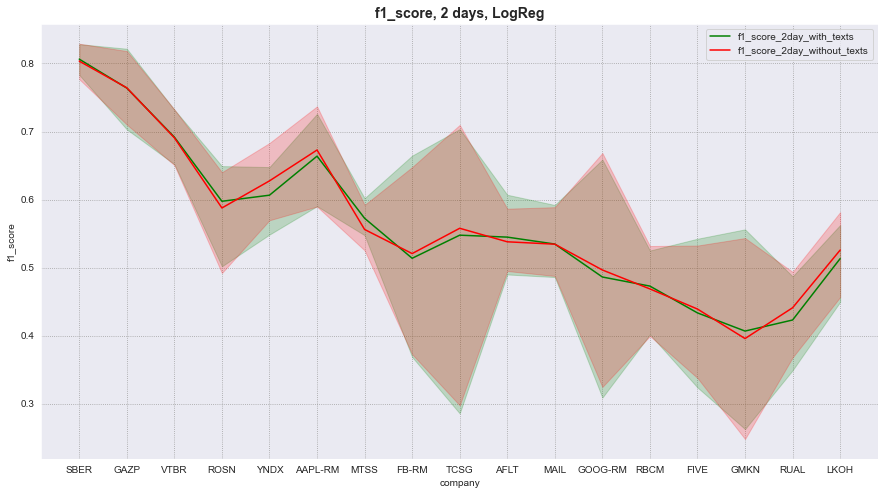

In [24]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 2 days, LogReg', weight='bold').set_fontsize('14')
metric = report_2[(report_2['period']=='2 days') & (report_2['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_2day_with_texts')
sns.lineplot(x=report_3[(report_3['period']=='2 days') & (report_3['model']=='Logistic Regression')]['company'],
             y=report_3[(report_3['period']=='2 days') & (report_3['model']=='Logistic Regression')]['f1_score'], color='red', label='f1_score_2day_without_texts')
plt.show()

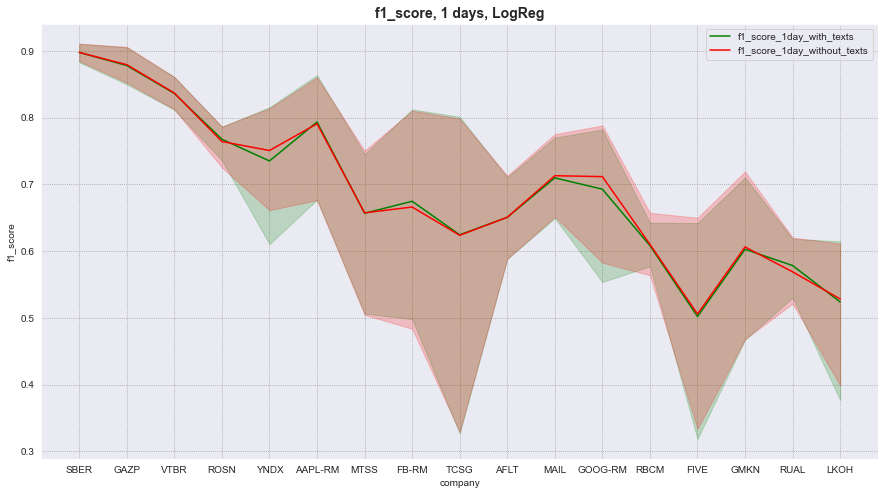

In [25]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 1 days, AdaBoost', weight='bold').set_fontsize('14')
metric = report_2[(report_2['period']=='1 day') & (report_2['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_1day_with_texts')
sns.lineplot(x=report_3[(report_3['period']=='1 day') & (report_3['model']=='Logistic Regression')]['company'],
             y=report_3[(report_3['period']=='1 day') & (report_3['model']=='Logistic Regression')]['f1_score'], color='red', label='f1_score_1day_without_texts')
plt.show()

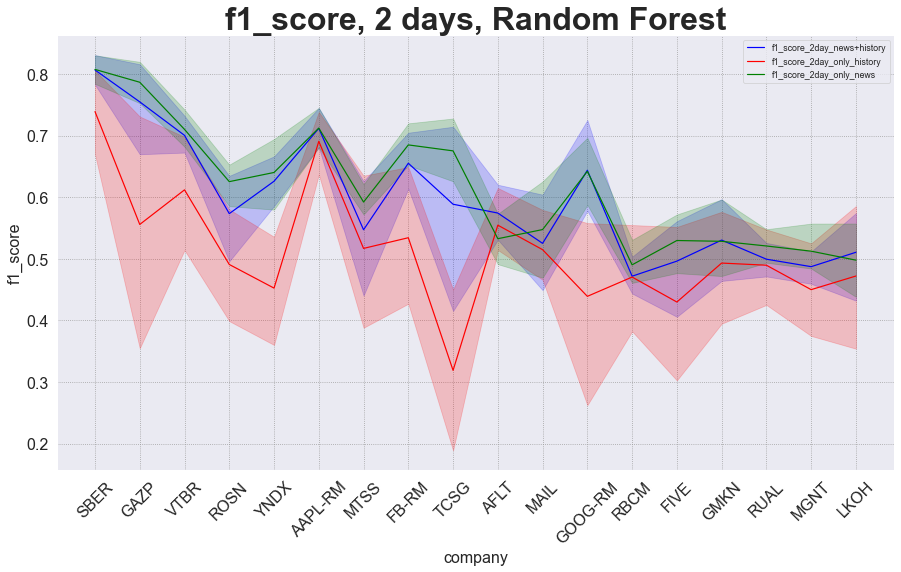

In [61]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 2 days, Random Forest', weight='bold').set_fontsize('32')
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":8,"axes.labelsize":16})
metric = report_2[(report_2['period']=='2 days') & (report_2['model']=='Random Forest')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='blue', label='f1_score_2day_news+history')
sns.lineplot(x=report_3[(report_3['period']=='2 days') & (report_3['model']=='Random Forest')]['company'],
             y=report_3[(report_3['period']=='2 days') & (report_3['model']=='Random Forest')]['f1_score'],
             color='red', label='f1_score_2day_only_history')
sns.lineplot(x=report_7[(report_7['period']=='2 days') & (report_7['model']=='Random Forest')]['company'],
             y=report_7[(report_7['period']=='2 days') & (report_7['model']=='Random Forest')]['f1_score'], color='green', label='f1_score_2day_only_news')
plt.tick_params(labelsize=16)

plt.xticks(rotation=45)
plt.show()

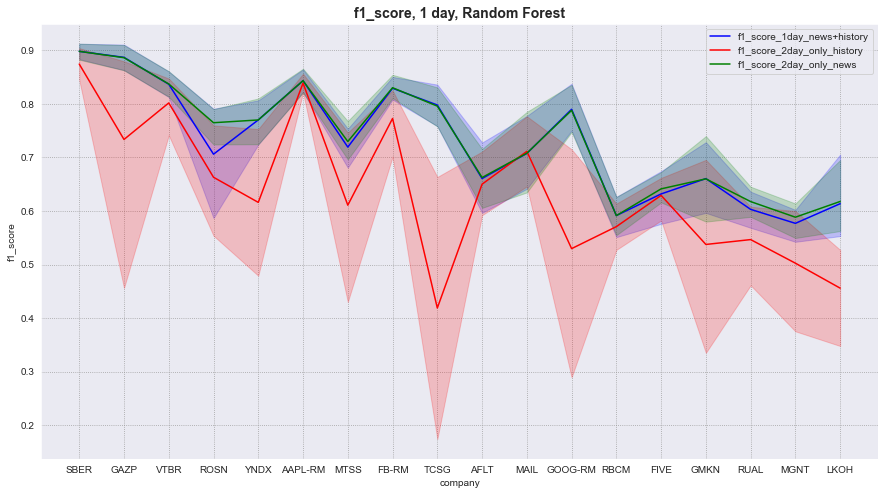

In [27]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 1 day, Random Forest', weight='bold').set_fontsize('14')
metric = report_2[(report_2['period']=='1 day') & (report_2['model']=='Random Forest')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='blue', label='f1_score_1day_news+history')
sns.lineplot(x=report_3[(report_3['period']=='1 day') & (report_3['model']=='Random Forest')]['company'],
             y=report_3[(report_3['period']=='1 day') & (report_3['model']=='Random Forest')]['f1_score'], color='red', label='f1_score_2day_only_history')
sns.lineplot(x=report_7[(report_7['period']=='1 day') & (report_7['model']=='Random Forest')]['company'],
             y=report_7[(report_7['period']=='1 day') & (report_7['model']=='Random Forest')]['f1_score'], color='green', label='f1_score_2day_only_news')
plt.show()

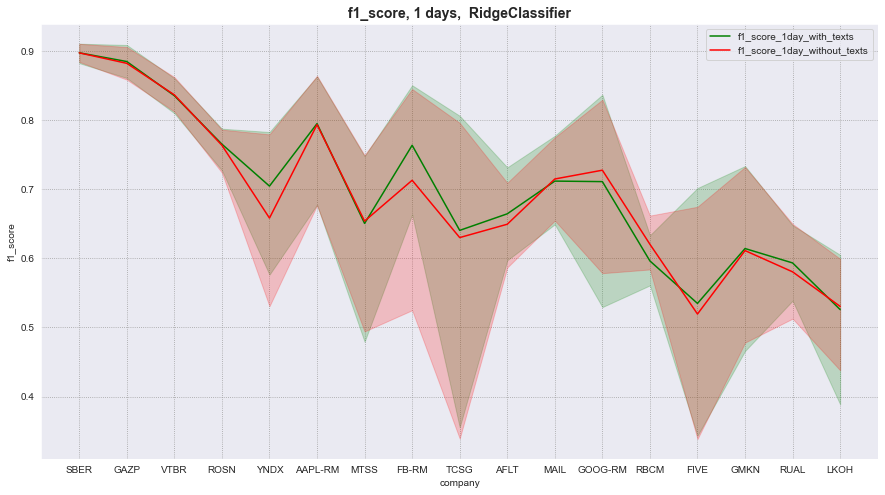

In [27]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 1 days,  RidgeClassifier', weight='bold').set_fontsize('14')
metric = report_2[(report_2['period']=='1 day') & (report_2['model']=='Ridge')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_1day_with_texts')
sns.lineplot(x=report_3[(report_3['period']=='1 day') & (report_3['model']=='Ridge')]['company'],
             y=report_3[(report_3['period']=='1 day') & (report_3['model']=='Ridge')]['f1_score'], color='red', label='f1_score_1day_without_texts')
plt.show()

# Только на текстах (не гнала)

In [149]:
def create_features(df, label=None):
    df['date'] = df.index
    #df['day'] = df['date'].dt.dayofweek
    #df['quarter'] = df['date'].dt.quarter
    #df['month'] = df['date'].dt.month
    #df['year'] = df['date'].dt.year
    #df['dayofyear'] = df['date'].dt.dayofyear
    #df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    df['delta'] = df['<CLOSE>'] - df['<CLOSE>'].shift(1)
    df['y_3'] = np.sign(df['delta'].shift(-1) - df['delta']+0.0001)

In [150]:
company = []
period = []
train = []
test = []
model = []
f1 = []

In [151]:
def scores_2(how):

    for ticker in ticker_list: 
        YNDX = res[res['<TICKER>'] == ticker]
        YNDX = YNDX[['<TICKER>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7', 
                     'lem_message', 'message']]
        YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date','y_3',
                             'y_7', 'message'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
        YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
        YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
        create_features(YNDX)
        #pd.get_dummies(YNDX, columns=['<TICKER>'])
        YNDX = YNDX.drop(labels=['date'], axis=1)
        YNDX = YNDX.dropna()
        Y_3 = YNDX['y_3']
        Y_7 = YNDX['y_7']
        YNDX = YNDX.drop(labels=['<TICKER>', 'y_3', 'y_7','message', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>'], axis=1)
        X = YNDX
        tscv = TimeSeriesSplit()
        
        print('Обучается '+ticker)
        for train_index, test_index in tscv.split(X): #я остановилась тут
            split_1 = train_index[-1]+1
            split_2 = test_index[-1]+1
            X_train, X_test = YNDX.iloc[:split_1, :], YNDX.iloc[split_1:split_2, :]
            y_train_3, y_test_3 = Y_3.iloc[:split_1], Y_3.iloc[split_1:split_2]
            y_train_7, y_test_7 = Y_7.iloc[:split_1], Y_7.iloc[split_1:split_2]

            res_1 = res.dropna()

            # train

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=1000)

            tfidf.fit(X_train['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])

            # test

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=1000)
            tfidf.fit(X_train['lem_message'])
            features_test = tfidf.transform(X_test['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])
            X_train = X_train.drop(labels=['lem_message'], axis=1)
            X_test = X_test.drop(labels=['lem_message'], axis=1)

            df_train, df_test = features_train.todense(), features_test.todense()

            X_data_train, X_data_test = df_train, df_test

            #print(X_data_train.shape, ' ',X_data_test.shape)
            #print('Обучается '+ticker)

            X_tr = np.array(X_data_train)
            y_tr_3 = np.array(y_train_3)
            y_tr_7 = np.array(y_train_7)

            clf1 = LogisticRegression(random_state=1,
                                      solver='newton-cg',
                                      multi_class='ovr')
            clf2 = RidgeClassifier()
            clf3 = SVC()
            clf4 = RandomForestClassifier()
            clf5 = AdaBoostClassifier()
            clf6 = DummyClassifier(strategy = 'uniform')
            labels = ['Logistic Regression', 'Ridge', 'SVM', 'Random Forest', 'AdaBoost', 'Rand']

            if how == 'report':


                models = [clf1, clf3]
                print('------------------------'+'1 day'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_3)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

                models = [clf1, clf3]
                print('------------------------'+'2 days'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_7)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

            elif how == 'table':

                # делаем таблицу
                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('1 day')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                    test.append(accuracy_score(y_test_3, y_predicted_test))
                    f1.append(f1_score(y_test_3, y_predicted_test,
                                                                            average = 'weighted'))
                    y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                    train.append(np.mean(y_train_3==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('2 days')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                    test.append(accuracy_score(y_test_7, y_predicted_test))
                    f1.append(f1_score(y_test_7, y_predicted_test, 
                                                                            average = 'weighted'))
                    y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                    train.append(np.mean(y_train_7==y_predicted_train))
        tab = {'f1_score':f1, 'company': company, 'period': period,'model': model, 'Train': train , 'Test': test}
        tabl = pd.DataFrame(tab, columns = ['company', 'period', 'model','Train', 'Test', 'f1_score'])

    if how == 'table':
        return tabl

In [152]:
report_4 = scores_2(how = 'table')


Обучается GOOG-RM
Обучается FIVE
Обучается SBER
Обучается RBCM
Обучается YNDX
Обучается AFLT
Обучается GMKN
Обучается GAZP
Обучается MAIL
Обучается MTSS
Обучается RUAL
Обучается TCSG
Обучается ROSN
Обучается FB-RM
Обучается LKOH
Обучается AAPL-RM
Обучается VTBR


In [153]:
report_4 = report_4.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

In [154]:
def scores_without_texts_2(how):

    for ticker in ticker_list: 
        YNDX = res[res['<TICKER>'] == ticker]
        YNDX = YNDX[['<TICKER>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3', 'y_7',
                     'lem_message', 'message']]
        YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date', 'y_3',
                             'y_7', 'message'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
        YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
        YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
        create_features(YNDX)
        #pd.get_dummies(YNDX, columns=['<TICKER>'])
        YNDX = YNDX.drop(labels=['date'], axis=1)
        YNDX = YNDX.dropna()
        Y_3 = YNDX['y_3']
        Y_7 = YNDX['y_7']
        YNDX = YNDX.drop(labels=['<TICKER>', 'y_3', 'y_7','message', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>' ], axis=1)
        X = YNDX
        tscv = TimeSeriesSplit()
        
        print('Обучается '+ticker)
        for train_index, test_index in tscv.split(X): #я остановилась тут
            split_1 = train_index[-1]+1
            split_2 = test_index[-1]+1
            X_train, X_test = YNDX.iloc[:split_1, :], YNDX.iloc[split_1:split_2, :]
            y_train_3, y_test_3 = Y_3.iloc[:split_1], Y_3.iloc[split_1:split_2]
            y_train_7, y_test_7 = Y_7.iloc[:split_1], Y_7.iloc[split_1:split_2]
            X_train = X_train.drop(labels=['lem_message'], axis=1)
            X_test = X_test.drop(labels=['lem_message'], axis=1)

            # train

            normalizer = preprocessing.StandardScaler()
            train_norm = normalizer.fit_transform(X_train)
            train_transformed = pd.DataFrame(data=train_norm, columns = X_train.columns)

            normalizer = preprocessing.StandardScaler()
            test_norm = normalizer.fit_transform(X_test)
            test_transformed = pd.DataFrame(data=test_norm, columns = X_test.columns)


            X_data_train, X_data_test = X_train, X_test

            #print(X_data_train.shape, ' ',X_data_test.shape)
            #print('Обучается '+ticker)

            X_tr = np.array(X_data_train)
            y_tr_3 = np.array(y_train_3)
            y_tr_7 = np.array(y_train_7)

            clf1 = LogisticRegression(random_state=1,
                                      solver='newton-cg',
                                  multi_class='ovr')
            clf2 = RidgeClassifier()
            clf3 = SVC()
            clf4 = RandomForestClassifier()
            clf5 = AdaBoostClassifier()
            clf6 = DummyClassifier(strategy = 'uniform')
            labels = ['Logistic Regression', 'Ridge', 'SVM', 'Random Forest', 'AdaBoost', 'Rand']

            if how == 'report':


                models = [clf1, clf2, clf3, clf4, clf5, clf6]
                print('------------------------'+'1 day'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_3)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

                models = [clf1, clf2, clf3, clf4, clf5, clf6]
                print('------------------------'+'2 days'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_7)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

            elif how == 'table':

                # делаем таблицу
                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('1 day')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                    test.append(np.mean(y_test_3==y_predicted_test))
                    f1.append(f1_score(y_test_3, y_predicted_test, 
                                                                            average = 'weighted'))
                    y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                    train.append(np.mean(y_train_3==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('2 days')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                    test.append(np.mean(y_test_7==y_predicted_test))
                    f1.append(f1_score(y_test_7, y_predicted_test, 
                                                                            average = 'weighted'))
                    y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                    train.append(np.mean(y_train_7==y_predicted_train))
                
        tab = {'f1_score':f1, 'company': company, 'period': period,'model': model, 'Train': train , 'Test': test}
        tabl = pd.DataFrame(tab, columns = ['company', 'period', 'model','Train', 'Test', 'f1_score'])

    if how == 'table':
        return tabl

In [155]:
company = []
period = []
train = []
test = []
model = []
f1 = []

In [156]:
report_5 = scores_without_texts_2(how = 'table')

In [157]:
report_5 = report_5.merge(num_of_news, right_on = '<TICKER>', left_on = 'company')

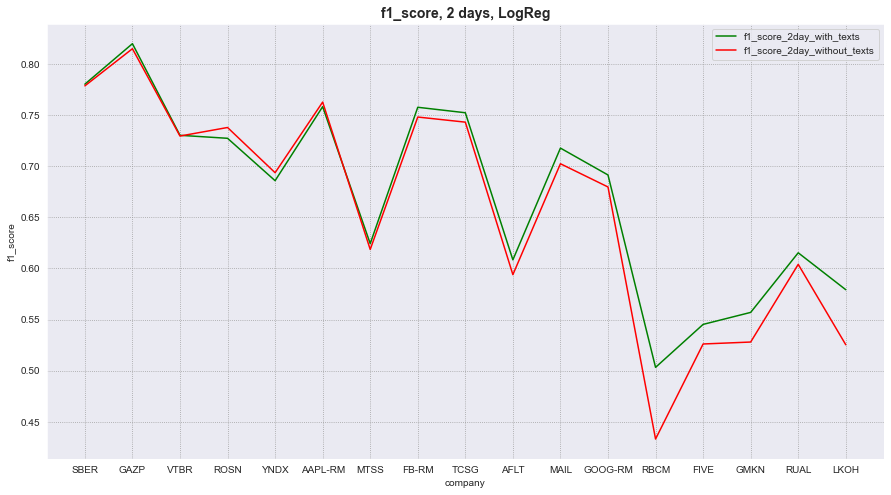

In [158]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 2 days, LogReg', weight='bold').set_fontsize('14')
metric = report_4[(report_4['period']=='2 days') & (report_4['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_2day_with_texts')
sns.lineplot(x=report_5[(report_5['period']=='2 days') & (report_5['model']=='Logistic Regression')]['company'],
             y=report_5[(report_5['period']=='2 days') & (report_5['model']=='Logistic Regression')]['f1_score'], color='red', label='f1_score_2day_without_texts')
plt.show()

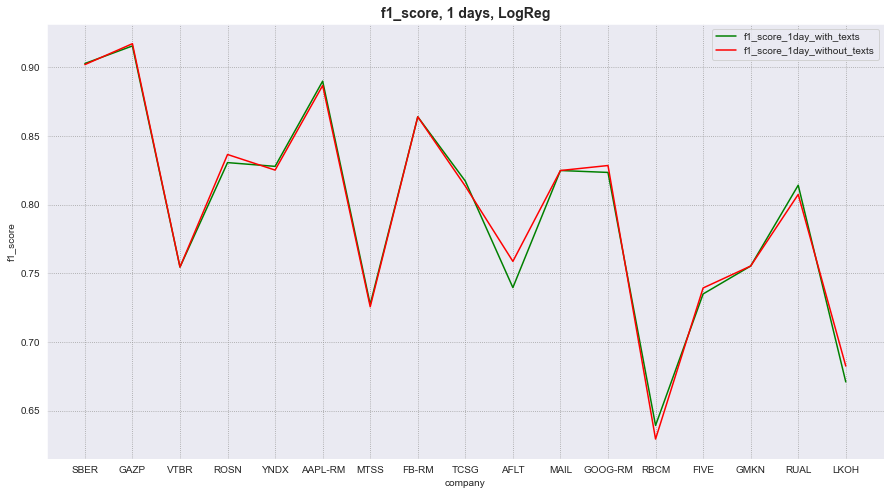

In [159]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 1 days, LogReg', weight='bold').set_fontsize('14')
metric = report_4[(report_4['period']=='1 day') & (report_4['model']=='Logistic Regression')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_1day_with_texts')
sns.lineplot(x=report_5[(report_5['period']=='1 day') & (report_5['model']=='Logistic Regression')]['company'],
             y=report_5[(report_5['period']=='1 day') & (report_5['model']=='Logistic Regression')]['f1_score'], color='red', label='f1_score_1day_without_texts')
plt.show()

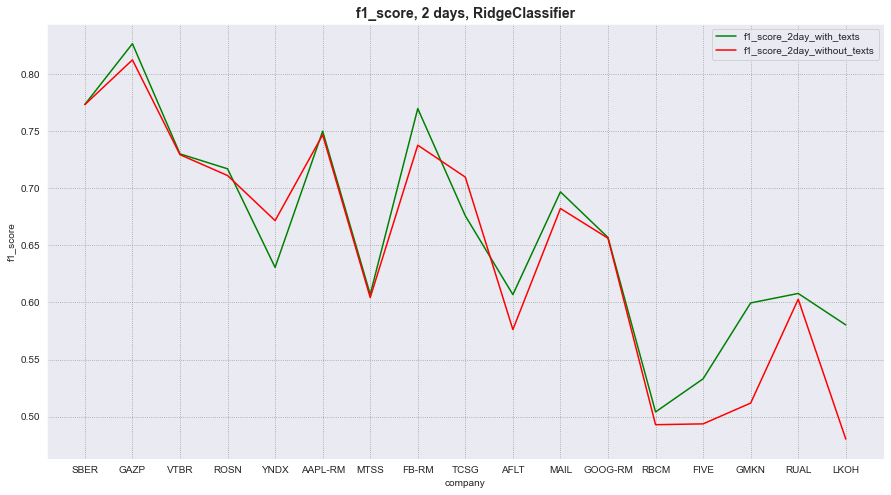

In [160]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 2 days, RidgeClassifier', weight='bold').set_fontsize('14')
metric = report_4[(report_4['period']=='2 days') & (report_4['model']=='Ridge')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_2day_with_texts')
sns.lineplot(x=report_5[(report_5['period']=='2 days') & (report_5['model']=='Ridge')]['company'],
             y=report_5[(report_5['period']=='2 days') & (report_5['model']=='Ridge')]['f1_score'], color='red', label='f1_score_2day_without_texts')
plt.show()

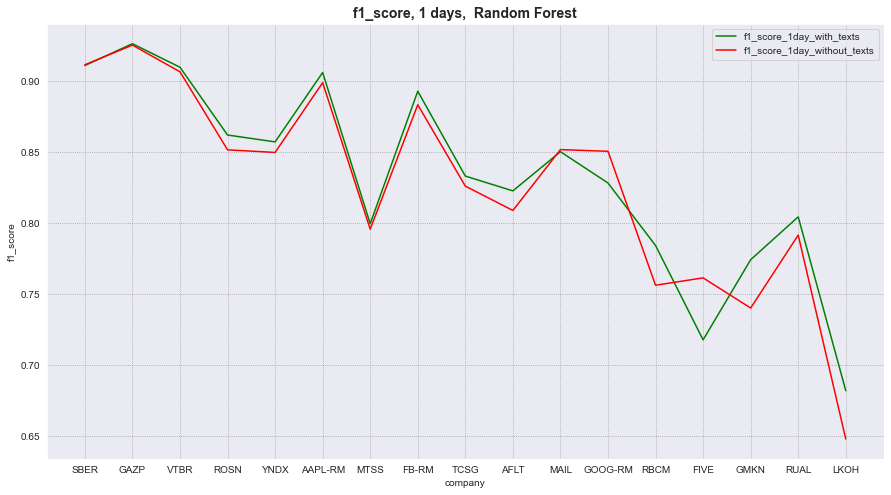

In [173]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.title('f1_score, 1 days,  Random Forest', weight='bold').set_fontsize('14')
metric = report_4[(report_4['period']=='1 day') & (report_4['model']=='Random Forest')].sort_values(by=['has news'], ascending=False)
sns.lineplot(x=metric['company'], y=metric['f1_score'], color='green', label='f1_score_1day_with_texts')
sns.lineplot(x=report_5[(report_5['period']=='1 day') & (report_5['model']=='Random Forest')]['company'],
             y=report_5[(report_5['period']=='1 day') & (report_5['model']=='Random Forest')]['f1_score'], color='red', label='f1_score_1day_without_texts')
plt.show()

In [162]:
f1_3 = pd.DataFrame(report_4[['company', 'period', 'model', 'f1_score']]
                    .groupby(['period', 'model'])['f1_score'].mean())
print('Модели с новостями')
f1_3

Модели с новостями


f1_score
period model                        
1 day  AdaBoost             0.792484
       Logistic Regression  0.795983
       Random Forest        0.833027
       Ridge                0.733735
       SVM                  0.799100
2 days AdaBoost             0.676956
       Logistic Regression  0.673691
       Random Forest        0.677143
       Ridge                0.662743
       SVM                  0.691521

In [163]:
f1_4 = pd.DataFrame(report_5[['company', 'period', 'model', 'f1_score']]
                    .groupby(['period', 'model'])['f1_score'].mean())
print('Модели без новостей')
f1_4

Модели без новостей


f1_score
period model                        
1 day  AdaBoost             0.843459
       Logistic Regression  0.797090
       Random Forest        0.826882
       Ridge                0.748662
       SVM                  0.819589
2 days AdaBoost             0.710111
       Logistic Regression  0.659943
       Random Forest        0.694854
       Ridge                0.646670
       SVM                  0.700628

# без всего

# Just tf-idf with CV

In [17]:
def create_features(df, label=None):

    df['y_3'] = np.sign(df['delta'].shift(-1) - df['delta']+0.0001)

In [18]:
company = []
period = []
train = []
test = []
model = []
f1 = []

In [19]:
def scores_4(how):

    for ticker in ticker_list: 
        YNDX = res[res['<TICKER>'] == ticker]
        YNDX = YNDX[['y_3', 'y_7', 
                     'lem_message', 'message', 'date']]
        #YNDX = YNDX.groupby(['<TICKER>','<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>','date','y_3',
                             #'y_7', 'message'])['lem_message'].apply(lambda x: ', '.join(x.astype(str))).reset_index()
        YNDX.sort_values(by = 'date', axis=0, ascending=True, inplace=True)
        #YNDX = YNDX.set_index(pd.DatetimeIndex(YNDX['date']))
        #create_features(YNDX)
        #pd.get_dummies(YNDX, columns=['<TICKER>'])
        YNDX = YNDX.dropna()
        Y_3 = YNDX['y_3']
        Y_7 = YNDX['y_7']
        YNDX = YNDX.drop(labels=['y_3', 'y_7','message','date'], axis=1)
        X = YNDX
        tscv = TimeSeriesSplit()
        
        print('Обучается '+ticker)
        for train_index, test_index in tscv.split(X): #я остановилась тут
            split_1 = train_index[-1]+1
            split_2 = test_index[-1]+1
            X_train, X_test = YNDX.iloc[:split_1, :], YNDX.iloc[split_1:split_2, :]
            y_train_3, y_test_3 = Y_3.iloc[:split_1], Y_3.iloc[split_1:split_2]
            y_train_7, y_test_7 = Y_7.iloc[:split_1], Y_7.iloc[split_1:split_2]

            res_1 = res.dropna()

            # train

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=1000)

            tfidf.fit(X_train['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])

            # test

            tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                                    ngram_range=(1,2), 
                                    stop_words=stop_words, max_features=1000)
            tfidf.fit(X_train['lem_message'])
            features_test = tfidf.transform(X_test['lem_message'])
            features_train = tfidf.transform(X_train['lem_message'])
            X_train = X_train.drop(labels=['lem_message'], axis=1)
            X_test = X_test.drop(labels=['lem_message'], axis=1)

            df_train, df_test = features_train.todense(), features_test.todense()

            X_data_train, X_data_test = df_train, df_test

            #print(X_data_train.shape, ' ',X_data_test.shape)
            #print('Обучается '+ticker)

            X_tr = np.array(X_data_train)
            y_tr_3 = np.array(y_train_3)
            y_tr_7 = np.array(y_train_7)

            clf1 = LogisticRegression(random_state=1,
                                      solver='newton-cg',
                                      multi_class='ovr')
            clf2 = RidgeClassifier()
            clf3 = SVC()
            clf4 = RandomForestClassifier()
            clf5 = AdaBoostClassifier()
            clf6 = DummyClassifier(strategy = 'prior')
            labels = ['Logistic Regression', 'Ridge', 'SVM', 'Random Forest', 'AdaBoost', 'Rand']

            if how == 'report':


                models = [clf1, clf3]
                print('------------------------'+'1 day'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_3)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_3, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

                models = [clf1, clf3]
                print('------------------------'+'2 days'+'------------------------')
                for clf, lab in zip(models, labels):
                    clf.fit(X_data_train, y_train_7)
                    print('------------------------'+ticker+'------------------------')
                    print('------------------------'+lab+'------------------------')
                    y_test_pred = clf.predict(X_data_test)
                    arg_test = {'y_true':y_test_7, 'y_pred':y_test_pred}
                    print(confusion_matrix(**arg_test))
                    print(classification_report(**arg_test))

            elif how == 'table':

                # делаем таблицу
                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('1 day')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_3).predict(X_data_test)
                    test.append(accuracy_score(y_test_3, y_predicted_test))
                    f1.append(f1_score(y_test_3, y_predicted_test,
                                                                            average = 'weighted'))
                    y_predicted_train = clf.fit(X_data_train, y_train_3).predict(X_data_train)
                    train.append(np.mean(y_train_3==y_predicted_train))

                for clf, lab in zip([clf1, clf2, clf3, clf4, clf5, clf6],
                                     labels):

                    company.append(ticker)
                    period.append('2 days')
                    model.append(lab)
                    y_predicted_test = clf.fit(X_data_train, y_train_7).predict(X_data_test)
                    test.append(accuracy_score(y_test_7, y_predicted_test))
                    f1.append(f1_score(y_test_7, y_predicted_test, 
                                                                            average = 'weighted'))
                    y_predicted_train = clf.fit(X_data_train, y_train_7).predict(X_data_train)
                    train.append(np.mean(y_train_7==y_predicted_train))
                #f1_cv.append(np.array(f1).mean())
        tab = {'f1_score':f1, 'company': company, 'period': period,'model': model, 'Train': train , 'Test': test}
        tabl = pd.DataFrame(tab, columns = ['company', 'period', 'model','Train', 'Test', 'f1_score'])
    if how == 'table':
        return tabl

In [20]:
report_7 = scores_4(how = 'table')

Обучается GOOG-RM
Обучается FIVE
Обучается SBER
Обучается RBCM
Обучается YNDX
Обучается AFLT
Обучается GMKN
Обучается MGNT
Обучается GAZP
Обучается MAIL
Обучается MTSS
Обучается RUAL
Обучается TCSG
Обучается ROSN
Обучается FB-RM
Обучается LKOH
Обучается AAPL-RM
Обучается VTBR


In [21]:
report_7

,company,period,model,Train,Test,f1_score
0,GOOG-RM,1 day,Logistic Regression,0.845161,0.826667,0.748224
1,GOOG-RM,1 day,Ridge,0.941935,0.826667,0.748224
2,GOOG-RM,1 day,SVM,0.877419,0.826667,0.748224
3,GOOG-RM,1 day,Random Forest,1.000000,0.826667,0.748224
4,GOOG-RM,1 day,AdaBoost,1.000000,0.706667,0.710906
...,...,...,...,...,...,...
1075,VTBR,2 days,Ridge,0.825653,0.772394,0.714357
1076,VTBR,2 days,SVM,0.855885,0.803231,0.716890
1077,VTBR,2 days,Random Forest,0.997358,0.798825,0.719950
1078,VTBR,2 days,AdaBoost,0.784855,0.772394,0.714357


In [22]:
f1_6 = pd.DataFrame(report_7[['company', 'period', 'model', 'f1_score', 'Test']]
                    .groupby(['period', 'model'])['f1_score', 'Test'].mean())
print('Модели с новостями')
f1_6

Модели с новостями


f1_score      Test
period model                                  
1 day  AdaBoost             0.720749  0.732021
       Logistic Regression  0.729427  0.808603
       Rand                 0.728331  0.810611
       Random Forest        0.734632  0.796179
       Ridge                0.736806  0.786928
       SVM                  0.728828  0.809550
2 days AdaBoost             0.610752  0.626045
       Logistic Regression  0.603469  0.689440
       Rand                 0.582120  0.700678
       Random Forest        0.612969  0.671402
       Ridge                0.614999  0.653680
       SVM                  0.595350  0.694587

In [23]:
pd.DataFrame(report_7[['company', 'period', 'model', 'f1_score', 'Test']]
                    .groupby(['period', 'model'])['f1_score', 'Test'].std())

f1_score      Test
period model                                  
1 day  AdaBoost             0.113742  0.118016
       Logistic Regression  0.117018  0.089226
       Rand                 0.118465  0.085948
       Random Forest        0.111856  0.099988
       Ridge                0.110940  0.105172
       SVM                  0.118030  0.087154
2 days AdaBoost             0.106042  0.110957
       Logistic Regression  0.120167  0.115533
       Rand                 0.138618  0.107381
       Random Forest        0.111114  0.115879
       Ridge                0.111400  0.118882
       SVM                  0.127250  0.112760

In [31]:
X = res[res['<TICKER>'] == 'SBER'].head(20)
tscv = TimeSeriesSplit(n_splits = 4)
for train_index, test_index in tscv.split(X):
    X = res[res['<TICKER>'] == 'SBER'].head(20)
    print("TRAIN:", train_index, "TEST:", test_index)
    print("TRAIN:", train_index[-1], "TEST:", test_index[-1])
    split_1 = train_index[-1]+1
    split_2 = test_index[-1]+1
    X_train, X_test = X.iloc[:split_1, :], X.iloc[split_1:split_2, :]
    print(len(X_train), len(X_test))

TRAIN: [0 1 2 3] TEST: [4 5 6 7]
TRAIN: 3 TEST: 7
4 4
TRAIN: [0 1 2 3 4 5 6 7] TEST: [ 8  9 10 11]
TRAIN: 7 TEST: 11
8 4
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12 13 14 15]
TRAIN: 11 TEST: 15
12 4
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16 17 18 19]
TRAIN: 15 TEST: 19
16 4


In [33]:
x = np.array([1,2,3,4]).mean()
x

2.5

# таблички

In [32]:
report_2.to_csv('f1_1_1day.csv')
report_3.to_csv('f1_2_1day.csv')
report_7.to_csv('f1_5_10day_onlynews.csv')

# стримлит

In [35]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 3.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 KB 3.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 KB 3.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 6.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.5/111.5 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 7.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.3/962.3 KB 6.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 KB 6.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 KB 2.1 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.5/339.5 KB 5.7 MB/s eta 0:00:0000:01
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13452 sha256=e0141bfb7ada687b88e53627d0971a8fcbe2b074ab938c5f1d42e646ccc19a06
  Stored in directory: /Users/dariagerasimenko/Library/Caches/pip/wheels/b7/a5/68/fe632054a5eadd531c7a49d740c50eb6adfbeca822b4eab8d4
  Created wheel for validators: filename=validators-0.19.0-py3-none-any.whl size=19539 sha256=2319b13b480f6fc12d7efea7fc5ffeb22900283e394f55323c50e4535e52175d
  Stored in directory: /Users/dariagerasimenko/Library/Caches/pip/wheels/44/50/f0/cb4b5b437aa8bb1f8417c877b27b0722d3f6b5f72f744fc8a3
Successfully built blinker validators
You should consider upgrading via the '/Users/dariagerasimenko/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [37]:
!streamlit hello


  👋 Welcome to Streamlit!

  If you're one of our development partners or you're interested in getting
  personal technical support or Streamlit updates, please enter your email
  address below. Otherwise, you may leave the field blank.

  Email: ^C
2022-05-15 13:47:28.919 


# графички

In [63]:
gazp = res[res['<TICKER>'] == 'GAZP']

In [65]:
gazp_1 = gazp[['message', '<CLOSE>', 'date', 'has news']]

In [70]:
gazp_1['has news'] = gazp_1['has news'].astype(int)


In [76]:
df_45 = gazp_1.groupby(['date', ])['has news'].sum().reset_index()

In [78]:
df_45 = pd.DataFrame(df_45)

In [81]:
g = gazp_1.merge(df_45, on = 'date', how = 'left')

In [83]:
g = gazp_1.groupby(['date', '<CLOSE>'])['has news'].sum().reset_index()

In [94]:
g['date'] = pd.to_datetime(g['date'])

In [96]:
g

,date,<CLOSE>,has news
0,2018-01-03,131.374340,0
1,2018-01-04,134.982593,3
2,2018-01-05,136.437925,0
3,2018-01-09,140.030566,3
4,2018-01-10,141.816792,1
...,...,...,...
1006,2021-12-24,337.787500,0
1007,2021-12-27,341.884300,0
1008,2021-12-28,345.028500,0
1009,2021-12-29,340.230900,0


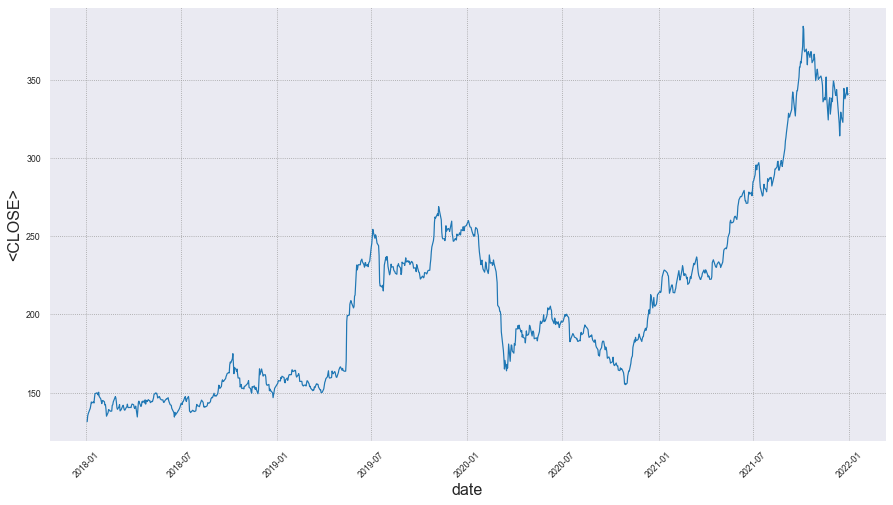

In [98]:
plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.lineplot(x="date", y="<CLOSE>", data=g)

plt.xticks(rotation=45)
plt.show()

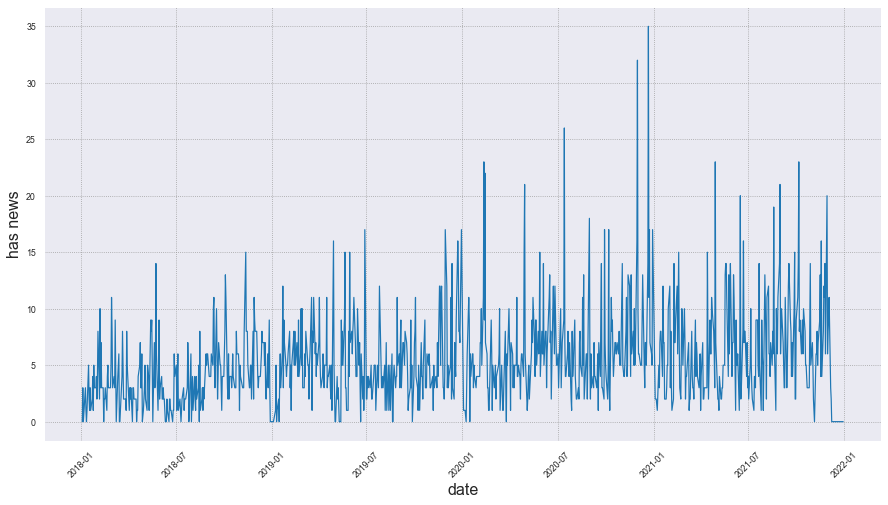

In [100]:


plt.figure(figsize=(15,8))
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.lineplot(x="date", y="has news", data=g)

plt.xticks(rotation=45)
plt.show()

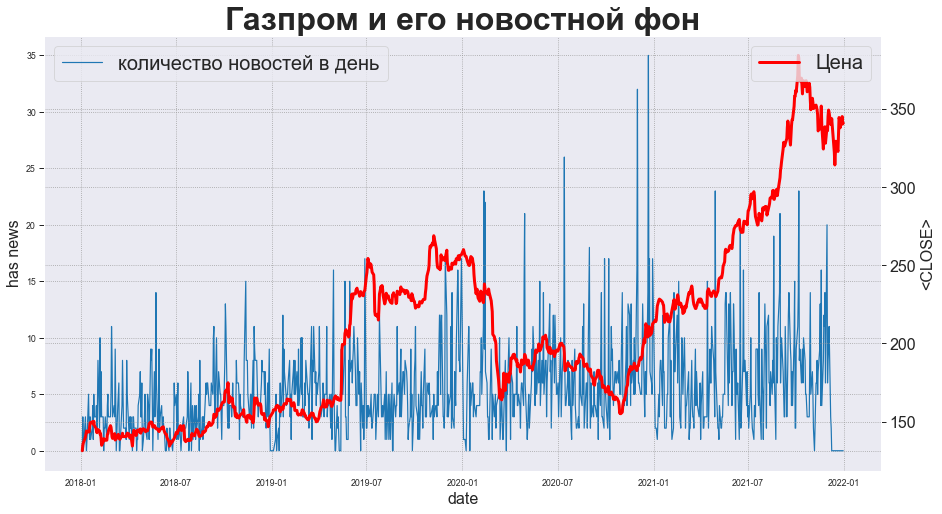

In [122]:
plt.figure(figsize=(15,8))
plt.title('Газпром и его новостной фон', weight='bold').set_fontsize('32')
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":18,"axes.labelsize":16})
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
ax = sns.lineplot(x="date", y="has news", data=g, label='количество новостей в день')
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":18,"axes.labelsize":16})
plt.legend(loc="upper left", frameon=True, fontsize=20)
ax2 = ax.twinx()

sns.lineplot(x="date", y="<CLOSE>", data=g, ax = ax2, color = 'red', label='Цена', linewidth = 3)
plt.tick_params(labelsize=16)
plt.xticks(rotation=45)
plt.legend(loc="upper right", frameon=True, fontsize=20)
plt.show()